In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt
import sys
import _pickle as cPickle
import gzip
import math
import numpy as np
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
display(tf.__version__)

# Helper function to display digit images
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
    grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
    grid_count = min(grid_count, len(images), len(labels))
  
    plt.figure(figsize=(2*grid_count, 2*grid_count))
    for i in range(sample_count):
        plt.subplot(grid_count, grid_count, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(images[i]), cmap=plt.cm.gray)
        plt.xlabel(labels[i])
    plt.show()
  

'2.7.0'

In [3]:
# I) load dataset 
# f = gzip.open('./data/mnist.pkl.gz', 'rb')
# if sys.version_info < (3,):
#     data = cPickle.load(f)
# else:
#     data = cPickle.load(f, encoding='bytes')
# f.close()
# (x_train, y_train), (x_test,y_test) = data

In [4]:
# # ----------------------------------------------------------------------------------------------------------------------------------------
# load pubgTest
pubgTestroot = '/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/speed_Detection/data/TestDigit/'
# pubgTestroot = '/local/mnt2/qtlvas/users/eshahria/workspace/COD/SpeedDetection/data/TestDigit/'
# pubgTestroot = '/local/mnt2/qtlvas/users/eshahria/workspace/HapticDetection/OCRDetection/data/LR1200TestByMuhua/'

pubgTrainroot = '/local/mnt3/workspace3/Kishore/ML_project_dir/ML_project_env/speed_Detection/data/SyntheticData/'
# pubgTrainroot='/local/mnt2/qtlvas/users/eshahria/workspace/COD/SpeedDetection/data/SyntheticData/'

Testfilelist= os.listdir(pubgTestroot)

x_test_pubg= np.zeros([len(Testfilelist),14,24,1])
y_test_pubg= np.zeros([len(Testfilelist),1])
for imgindex in range(len(Testfilelist)):     
    #print(imgindex)
    
    
      # x_test_pubg[imgindex,:,:,0]= cv2.imread(pubgTestroot+Testfilelist[imgindex],0)[255:269,787:811]
      # x_test_pubg[imgindex,:,:,0]= cv2.imread(pubgTestroot+Testfilelist[imgindex],0)[:-1,0:24]
    imgcrop  = cv2.imread(pubgTestroot+Testfilelist[imgindex],0)
    # imgcropscaled = cv2.resize(imgcrop, (24,14))
    x_test_pubg[imgindex,:,:,0]=imgcrop
    label = Testfilelist[imgindex][0:3]
    spindex= label.find('_')
    if spindex>0:
         label=label[:spindex]
    y_test_pubg[imgindex,0]= int(label)
      # x_test_pubg[imgindex,:,:,0]= cv2.imread(pubgTestroot+Testfilelist[imgindex],0)
      # y_test_pubg[imgindex,0]= int(Testfilelist[imgindex][0:3])
x_test_pubg=x_test_pubg/255.00
# y_test_pubg = y_test_pubg
filelist= os.listdir(pubgTrainroot)
np.random.shuffle((filelist))
x_train_pubg= np.zeros([len(filelist),14,24,1])
y_train_pubg= np.zeros([len(filelist),1])
for imgindex in range(len(filelist)):
     
     x_train_pubg[imgindex,:,:,0]= cv2.imread(pubgTrainroot+filelist[imgindex],0)
     label = filelist[imgindex][0:3]
     spindex= label.find('_')
     if spindex>0:
         label=label[:spindex]
     y_train_pubg[imgindex,0]= int(label)
x_train_pubg=x_train_pubg/255.00


In [5]:
# -----------------------------------------------------------------------------
# x_train = x_train/255.0
# x_test = x_test/255.0

# show_sample(x_train, y_train)

num_orientation= 301
# Mnist model -------------------
# Define the model architecture
model = keras.Sequential([
    # keras.layers.Flatten(input_shape=(14, 20,1)),
    # keras.layers.Dense(128, activation=tf.nn.relu),

# Optional: You can replace the dense layer above with the convolution layers below to get higher accuracy.
    # keras.layers.Reshape(target_shape=( 14, 20, 1)),    
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu, input_shape = (14, 24, 1), name='input'),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(input_shape=(14, 24)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(num_orientation, name='output')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 12, 22, 16)        160       
                                                                 
 conv2d (Conv2D)             (None, 10, 20, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 10, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 10, 16)         0         
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                51264     
                                                        

In [6]:
# model training  -------------------------------------------------------------

# Train the digit classification model
#model.fit(x_train, y_train, epochs=5)
testaccset=[]
for k in range(20):
    
    model.fit(x_train_pubg, y_train_pubg, batch_size=1024, epochs=30)
    test_loss, test_acc = model.evaluate(x_test_pubg, y_test_pubg)
    testaccset.append(test_acc)

model.save('./CODSpeedChkpnt_Jan26')


# # model evaluation predict pubg images ---------

# test_loss, test_acc = model.evaluate(x_test_pubg, y_test_pubg)
# predictions_pubg = model.predict(x_test_pubg)
# show_sample(x_test_pubg,['Predicted: %d' % (np.argmax(result)) for result in predictions_pubg])

# test_loss, test_acc = model.evaluate(x_train_pubg, y_train_pubg)
# predictions_pubg = model.predict(x_train_pubg)
# show_sample(x_train_pubg,['Predicted: %d' % (np.argmax(result)) for result in predictions_pubg])



Epoch 1/30
4/4 [==============================] - 0s 29ms/step - loss: 5.6251 - accuracy: 0.0820
Epoch 2/30
4/4 [==============================] - 0s 27ms/step - loss: 5.3854 - accuracy: 0.2447
Epoch 3/30
4/4 [==============================] - 0s 29ms/step - loss: 5.2082 - accuracy: 0.2488
Epoch 4/30
4/4 [==============================] - 0s 28ms/step - loss: 5.1707 - accuracy: 0.2500
Epoch 5/30
4/4 [==============================] - 0s 27ms/step - loss: 5.0807 - accuracy: 0.2500
Epoch 6/30
4/4 [==============================] - 0s 28ms/step - loss: 4.9813 - accuracy: 0.2500
Epoch 7/30
4/4 [==============================] - 0s 28ms/step - loss: 4.9291 - accuracy: 0.2500
Epoch 8/30
4/4 [==============================] - 0s 28ms/step - loss: 4.8336 - accuracy: 0.2500
Epoch 9/30
4/4 [==============================] - 0s 28ms/step - loss: 4.7606 - accuracy: 0.2500
Epoch 10/30
4/4 [==============================] - 0s 27ms/step - loss: 4.6661 - accuracy: 0.2500
Epoch 11/30
4/4 [============

4/4 [==============================] - 0s 28ms/step - loss: 2.4133 - accuracy: 0.3837
Epoch 24/30
4/4 [==============================] - 0s 29ms/step - loss: 2.4119 - accuracy: 0.3880
Epoch 25/30
4/4 [==============================] - 0s 28ms/step - loss: 2.3726 - accuracy: 0.3968
Epoch 26/30
4/4 [==============================] - 0s 27ms/step - loss: 2.3616 - accuracy: 0.3893
Epoch 27/30
4/4 [==============================] - 0s 27ms/step - loss: 2.3228 - accuracy: 0.4033
Epoch 28/30
4/4 [==============================] - 0s 27ms/step - loss: 2.2954 - accuracy: 0.4098
Epoch 29/30
4/4 [==============================] - 0s 30ms/step - loss: 2.2877 - accuracy: 0.4095
Epoch 30/30
4/4 [==============================] - 0s 2ms/step - loss: 2.9675 - accuracy: 0.3900
Epoch 1/30
4/4 [==============================] - 0s 27ms/step - loss: 2.2394 - accuracy: 0.4148
Epoch 2/30
4/4 [==============================] - 0s 27ms/step - loss: 2.2074 - accuracy: 0.4205
Epoch 3/30
4/4 [===================

4/4 [==============================] - 0s 28ms/step - loss: 1.4088 - accuracy: 0.5810
Epoch 15/30
4/4 [==============================] - 0s 27ms/step - loss: 1.3383 - accuracy: 0.6062
Epoch 16/30
4/4 [==============================] - 0s 28ms/step - loss: 1.3866 - accuracy: 0.5900
Epoch 17/30
4/4 [==============================] - 0s 29ms/step - loss: 1.3343 - accuracy: 0.6003
Epoch 18/30
4/4 [==============================] - 0s 28ms/step - loss: 1.3629 - accuracy: 0.5895
Epoch 19/30
4/4 [==============================] - 0s 27ms/step - loss: 1.3396 - accuracy: 0.6003
Epoch 20/30
4/4 [==============================] - 0s 28ms/step - loss: 1.3426 - accuracy: 0.5978
Epoch 21/30
4/4 [==============================] - 0s 28ms/step - loss: 1.3629 - accuracy: 0.5947
Epoch 22/30
4/4 [==============================] - 0s 28ms/step - loss: 1.3354 - accuracy: 0.6020
Epoch 23/30
4/4 [==============================] - 0s 28ms/step - loss: 1.3212 - accuracy: 0.5982
Epoch 24/30
4/4 [===============

4/4 [==============================] - 0s 28ms/step - loss: 0.9928 - accuracy: 0.6905
Epoch 6/30
4/4 [==============================] - 0s 28ms/step - loss: 0.9762 - accuracy: 0.6990
Epoch 7/30
4/4 [==============================] - 0s 27ms/step - loss: 0.9874 - accuracy: 0.6948
Epoch 8/30
4/4 [==============================] - 0s 28ms/step - loss: 0.9909 - accuracy: 0.6970
Epoch 9/30
4/4 [==============================] - 0s 27ms/step - loss: 0.9619 - accuracy: 0.7032
Epoch 10/30
4/4 [==============================] - 0s 28ms/step - loss: 0.9755 - accuracy: 0.6992
Epoch 11/30
4/4 [==============================] - 0s 28ms/step - loss: 0.9428 - accuracy: 0.7092
Epoch 12/30
4/4 [==============================] - 0s 28ms/step - loss: 0.9593 - accuracy: 0.7055
Epoch 13/30
4/4 [==============================] - 0s 29ms/step - loss: 0.9846 - accuracy: 0.6930
Epoch 14/30
4/4 [==============================] - 0s 28ms/step - loss: 0.9646 - accuracy: 0.7023
Epoch 15/30
4/4 [===================

4/4 [==============================] - 0s 28ms/step - loss: 0.7756 - accuracy: 0.7575
Epoch 28/30
4/4 [==============================] - 0s 30ms/step - loss: 0.7476 - accuracy: 0.7607
Epoch 29/30
4/4 [==============================] - 0s 28ms/step - loss: 0.7475 - accuracy: 0.7602
Epoch 30/30
4/4 [==============================] - 0s 1ms/step - loss: 2.8166 - accuracy: 0.6400
Epoch 1/30
4/4 [==============================] - 0s 28ms/step - loss: 0.7194 - accuracy: 0.7682
Epoch 2/30
4/4 [==============================] - 0s 28ms/step - loss: 0.7341 - accuracy: 0.7667
Epoch 3/30
4/4 [==============================] - 0s 28ms/step - loss: 0.7437 - accuracy: 0.7577
Epoch 4/30
4/4 [==============================] - 0s 28ms/step - loss: 0.7238 - accuracy: 0.7638
Epoch 5/30
4/4 [==============================] - 0s 28ms/step - loss: 0.7216 - accuracy: 0.7692
Epoch 6/30
4/4 [==============================] - 0s 28ms/step - loss: 0.7403 - accuracy: 0.7642
Epoch 7/30
4/4 [=======================

4/4 [==============================] - 0s 28ms/step - loss: 0.5910 - accuracy: 0.8077
Epoch 19/30
4/4 [==============================] - 0s 28ms/step - loss: 0.6137 - accuracy: 0.8045
Epoch 20/30
4/4 [==============================] - 0s 27ms/step - loss: 0.5888 - accuracy: 0.8075
Epoch 21/30
4/4 [==============================] - 0s 27ms/step - loss: 0.5822 - accuracy: 0.8005
Epoch 22/30
4/4 [==============================] - 0s 27ms/step - loss: 0.5917 - accuracy: 0.8065
Epoch 23/30
4/4 [==============================] - 0s 29ms/step - loss: 0.5933 - accuracy: 0.8058
Epoch 24/30
4/4 [==============================] - 0s 28ms/step - loss: 0.6141 - accuracy: 0.7965
Epoch 25/30
4/4 [==============================] - 0s 28ms/step - loss: 0.5952 - accuracy: 0.8010
Epoch 26/30
4/4 [==============================] - 0s 27ms/step - loss: 0.6022 - accuracy: 0.8058
Epoch 27/30
4/4 [==============================] - 0s 28ms/step - loss: 0.5840 - accuracy: 0.8098
Epoch 28/30
4/4 [===============

4/4 [==============================] - 0s 28ms/step - loss: 0.5052 - accuracy: 0.8342
Epoch 10/30
4/4 [==============================] - 0s 28ms/step - loss: 0.5179 - accuracy: 0.8192
Epoch 11/30
4/4 [==============================] - 0s 28ms/step - loss: 0.5120 - accuracy: 0.8335
Epoch 12/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4992 - accuracy: 0.8350
Epoch 13/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4975 - accuracy: 0.8363
Epoch 14/30
4/4 [==============================] - 0s 28ms/step - loss: 0.5112 - accuracy: 0.8380
Epoch 15/30
4/4 [==============================] - 0s 27ms/step - loss: 0.4750 - accuracy: 0.8403
Epoch 16/30
4/4 [==============================] - 0s 28ms/step - loss: 0.5062 - accuracy: 0.8310
Epoch 17/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4981 - accuracy: 0.8357
Epoch 18/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4934 - accuracy: 0.8445
Epoch 19/30
4/4 [===============

4/4 [==============================] - 0s 1ms/step - loss: 3.1222 - accuracy: 0.6900
Epoch 1/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4270 - accuracy: 0.8610
Epoch 2/30
4/4 [==============================] - 0s 29ms/step - loss: 0.4366 - accuracy: 0.8533
Epoch 3/30
4/4 [==============================] - 0s 29ms/step - loss: 0.4291 - accuracy: 0.8540
Epoch 4/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4361 - accuracy: 0.8482
Epoch 5/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4304 - accuracy: 0.8525
Epoch 6/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4156 - accuracy: 0.8610
Epoch 7/30
4/4 [==============================] - 0s 29ms/step - loss: 0.4352 - accuracy: 0.8518
Epoch 8/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4314 - accuracy: 0.8575
Epoch 9/30
4/4 [==============================] - 0s 28ms/step - loss: 0.4339 - accuracy: 0.8547
Epoch 10/30
4/4 [=========================

4/4 [==============================] - 0s 2ms/step - loss: 3.2227 - accuracy: 0.6800


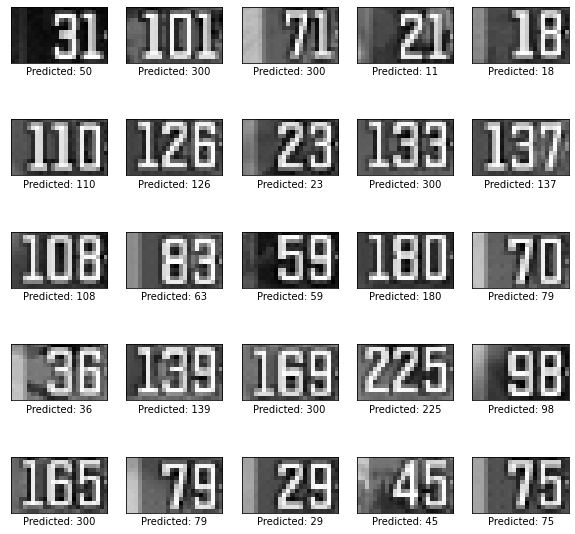

125/125 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 1.0000


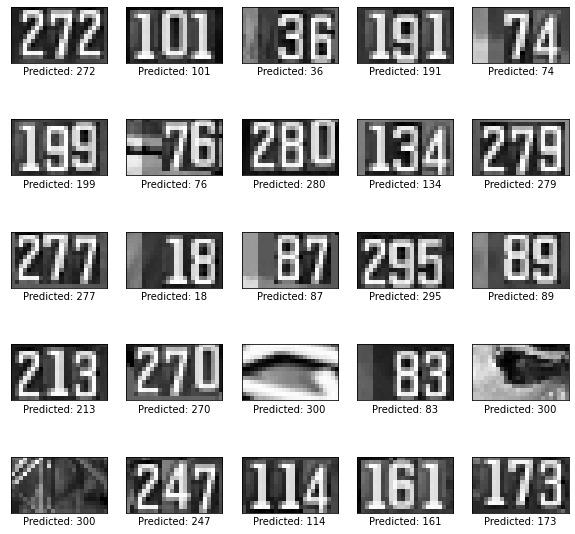

In [7]:
# # model evaluation predict pubg images ---------

test_loss, test_acc = model.evaluate(x_test_pubg, y_test_pubg)
predictions_pubg = model.predict(x_test_pubg)
show_sample(x_test_pubg,['Predicted: %d' % (np.argmax(result)) for result in predictions_pubg])

test_loss, test_acc = model.evaluate(x_train_pubg, y_train_pubg)
predictions_pubg = model.predict(x_train_pubg)
show_sample(x_train_pubg,['Predicted: %d' % (np.argmax(result)) for result in predictions_pubg])

In [8]:
# load model 
model = keras.models.load_model('./CODSpeedChkpnt_Jan26')
model.summary()

# model Evaluation ------------------------------------------------------------
# test_loss, test_acc = model.evaluate(x_test, y_test)

# print('Test accuracy:', test_acc)



# Predict the MNIST digits 
# predictions = model.predict(x_test)

# # Then plot the first 25 test images and their predicted labels.
# show_sample(x_test,  ['Predicted: %d' % np.argmax(result) for result in predictions])




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 12, 22, 16)        160       
                                                                 
 conv2d (Conv2D)             (None, 10, 20, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 10, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 10, 16)         0         
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                51264     
                                                        

In [9]:
# Save  TFLite model ----------------------------------------------------------
model = keras.models.load_model('./CODSpeedChkpnt_Jan26')
model.summary()
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model as file
f = open('COD_speed_Jan26.tflite', "wb")
f.write(tflite_model)
f.close()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 12, 22, 16)        160       
                                                                 
 conv2d (Conv2D)             (None, 10, 20, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 10, 16)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 10, 16)         0         
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                51264     
                                                        